# COGS 108 - EDA Checkpoint

# Names

- Serena Tang
- Jeffrey Luu
- Benjamin Hofflich
- Faris Ashai
- Steven Won

<a id='research_question'></a>
# Research Question

Can we use a city's age adjusted prevalence of obesity, diabetes, high cholesterol, stroke, and kidney disease to accurately predict the average income level by state?

# Setup

In [1]:
# import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.style as style
# set plotting size parameter
plt.rcParams['figure.figsize'] = (17, 7)

# Statmodels & patsy
import patsy
import statsmodels.api as sm

import pandas as pd
import numpy as np
import seaborn as sns
sns.set()
sns.set_context('talk')

import warnings
warnings.filterwarnings('ignore')

# load data
CDC_health_df=pd.read_csv('https://chronicdata.cdc.gov/api/views/dxpw-cm5u/rows.csv')
IRS_income_df=pd.read_csv('https://www.irs.gov/pub/irs-soi/17zpallnoagi.csv')
zipcodes_df=pd.read_csv('uszips.csv')

# Data Cleaning

- The CDC dataset (`CDC_health_df`) will be truncated to show the city, state, population in 2010, and a model-based estimate for the crude and age adjusted of obesity in adults; each will be renamed for clarity. Additionally, we will drop any rows with missing information.
- The IRS dataset (`IRS_income_df`) will be truncated to show the state, zipcode, and the total income amount; each of these column names were renamed for clarity. Additionally, we will drop any rows with missing information.
- The Zipcode dataset (`zipcodes_df`) will be truncated to show the zipcode, city, and state abbreviation; each of these column names were renamed for clarity. Additionally, we will drop any rows with missing information.
- The IRS dataset and the zipcode data set were combined to map a zipcode to its city (`city_income_df`); this allows us to relate the income of different parts of a city to the entire city. Additionally, as the IRS income data is reported as the total income that zipcode makes, it was divided by the number of returns to understand the average income of a city's population.
- The city-income dataset (`city_income_df`) was then combined with the CDC dataset (`CDC_health_df`) to allow us to relate a city's income to its obesity prevalence. Finally, the average incomes (based on the zipcode) for a city was then averaged to determine a city's average income. Additionally, the income data was normalised such that the income values range from 0 to 100.

In [2]:
#Load CDC Obesity Data by State and City
CDC_health_df=CDC_health_df[['StateAbbr','PlaceName','Population2010','OBESITY_AdjPrev',
                             'DIABETES_AdjPrev','HIGHCHOL_AdjPrev','SLEEP_AdjPrev','STROKE_AdjPrev','KIDNEY_AdjPrev']]
CDC_health_df.columns=['State','City','Population','Obesity','Diabetes','HighChol','Sleep','Stroke','Kidney']
CDC_health_df=CDC_health_df.dropna(how='all')
CDC_health_df.head()

,State,City,Population,Obesity,Diabetes,HighChol,Sleep,Stroke,Kidney
0,AL,Birmingham,212237,42.0,16.2,31.9,41.8,5.1,4.0
1,AL,Hoover,81619,28.4,8.1,30.1,32.8,2.3,2.4
2,AL,Huntsville,180105,36.2,11.4,30.3,38.3,3.5,3.1
3,AL,Mobile,195111,38.2,13.5,31.5,39.7,4.2,3.5
4,AL,Montgomery,205764,39.0,14.3,32.2,38.1,4.2,3.6


In [3]:
#Load Income data and # of tax returns by State and Zipcode
IRS_income_df=IRS_income_df[['STATE','ZIPCODE','N1','A02650']]
IRS_income_df.columns=['State','Zipcode','Returns','Income']
IRS_income_df=IRS_income_df.dropna(how='all')
IRS_income_df.head()

,State,Zipcode,Returns,Income
0,AL,0,2033660.0,121036654.0
1,AL,35004,5130.0,292671.0
2,AL,35005,3170.0,125810.0
3,AL,35006,1210.0,59725.0
4,AL,35007,11930.0,714402.0


In [4]:
#Load Zipcode data
zipcodes_df=zipcodes_df[['zip','city','state_id']]
zipcodes_df.columns=['Zipcode','City','State']
zipcodes_df=zipcodes_df.dropna(how='all')
zipcodes_df.head()

,Zipcode,City,State
0,601,Adjuntas,PR
1,602,Aguada,PR
2,603,Aguadilla,PR
3,606,Maricao,PR
4,610,Anasco,PR


In [5]:
#Merge Zipcodes and Cities to get income by Zipcode
city_income_df = pd.merge(IRS_income_df,zipcodes_df,on = ['Zipcode','State'])
city_income_df.drop('Zipcode', axis=1, inplace=True)
city_income_df.dropna(how = 'all', inplace = True)
city_income_df['Income']=city_income_df['Income']/city_income_df['Returns']*1000
city_income_df.drop('Returns', axis=1, inplace=True)
city_income_df.head()

,State,Income,City
0,AL,57050.877193,Moody
1,AL,39687.697161,Adamsville
2,AL,49359.504132,Adger
3,AL,59882.816429,Alabaster
4,AL,49622.686946,Alexander City


In [6]:
#Merge Obesity and Income Data
income_obesity_df = pd.merge(city_income_df,CDC_health_df, on = ['State','City'])
income_obesity_df.head()

,State,Income,City,Population,Obesity,Diabetes,HighChol,Sleep,Stroke,Kidney
0,AL,125635.947712,Birmingham,212237,42.0,16.2,31.9,41.8,5.1,4.0
1,AL,25578.796562,Birmingham,212237,42.0,16.2,31.9,41.8,5.1,4.0
2,AL,59242.015707,Birmingham,212237,42.0,16.2,31.9,41.8,5.1,4.0
3,AL,30977.404580,Birmingham,212237,42.0,16.2,31.9,41.8,5.1,4.0
4,AL,25947.923323,Birmingham,212237,42.0,16.2,31.9,41.8,5.1,4.0


In [7]:
#Income statistics by city (Labels not yet added)
city_income_stats = income_obesity_df.groupby(['State','City'], as_index=False).describe().Income
city_income_stats.head()

,count,mean,std,min,25%,50%,75%,max
0,10.0,80082.071574,27250.331571,56511.271298,60504.617100,77610.355423,84213.541563,149529.906542
1,28.0,76833.030036,72273.073614,25578.796562,29968.863049,40310.828036,100322.605431,335398.913043
2,10.0,69611.894834,31858.476347,26571.163366,41076.803264,75812.810234,91339.734075,122208.576998
3,16.0,48140.928722,20011.566339,22539.000000,30926.396986,44714.246872,63097.060664,86580.983182
4,12.0,50277.532893,19466.386427,27329.139073,32866.644477,46270.325944,68899.262126,80899.237805


In [8]:
#Average Income by city
income_obesity_df=income_obesity_df.groupby(['State','City'], as_index=False).mean()
#income_obesity_df['Income']=income_obesity_df['Income']/max(income_obesity_df['Income'])*100
income_obesity_df

,State,City,Income,Population,Obesity,Diabetes,HighChol,Sleep,Stroke,Kidney
0,AK,Anchorage,80082.071574,291826,34.1,8.1,29.2,30.7,2.6,2.6
1,AL,Birmingham,76833.030036,212237,42.0,16.2,31.9,41.8,5.1,4.0
2,AL,Huntsville,69611.894834,180105,36.2,11.4,30.3,38.3,3.5,3.1
3,AL,Mobile,48140.928722,195111,38.2,13.5,31.5,39.7,4.2,3.5
4,AL,Montgomery,50277.532893,205764,39.0,14.3,32.2,38.1,4.2,3.6
...,...,...,...,...,...,...,...,...,...,...
466,WI,Milwaukee,55715.968969,594833,36.2,11.3,29.6,39.2,4.1,3.7
467,WI,Racine,54268.532091,78860,40.2,10.1,30.7,39.8,3.4,3.3
468,WI,Waukesha,73482.491157,70718,31.5,7.5,29.1,33.2,2.5,2.6
469,WV,Charleston,62930.969785,51400,38.8,12.9,33.0,40.3,3.3,3.1


In [9]:
#Add labels to city income statistics
city_income_stats["State"]=income_obesity_df.State
city_income_stats["City"]=income_obesity_df.City
city_income_stats = city_income_stats[["State", "City", "count", "mean", "std", "min", "25%", "50%", "75%", "max"]]
city_income_stats.head()

,State,City,count,mean,std,min,25%,50%,75%,max
0,AK,Anchorage,10.0,80082.071574,27250.331571,56511.271298,60504.617100,77610.355423,84213.541563,149529.906542
1,AL,Birmingham,28.0,76833.030036,72273.073614,25578.796562,29968.863049,40310.828036,100322.605431,335398.913043
2,AL,Huntsville,10.0,69611.894834,31858.476347,26571.163366,41076.803264,75812.810234,91339.734075,122208.576998
3,AL,Mobile,16.0,48140.928722,20011.566339,22539.000000,30926.396986,44714.246872,63097.060664,86580.983182
4,AL,Montgomery,12.0,50277.532893,19466.386427,27329.139073,32866.644477,46270.325944,68899.262126,80899.237805


# Data Analysis & Results (EDA)

For each numerical variable in the income_obesity_df dataframe, a density plot was created to understand the distribution of its values; a density plot was created for income, obesity, sleep, kidney disease, high cholesterol, stroke, and diabetes. 

The following plot presents the distribution of the normalised, average income of each city based on the number of tax returns.

Text(0.5, 1.0, 'Income Distribution')

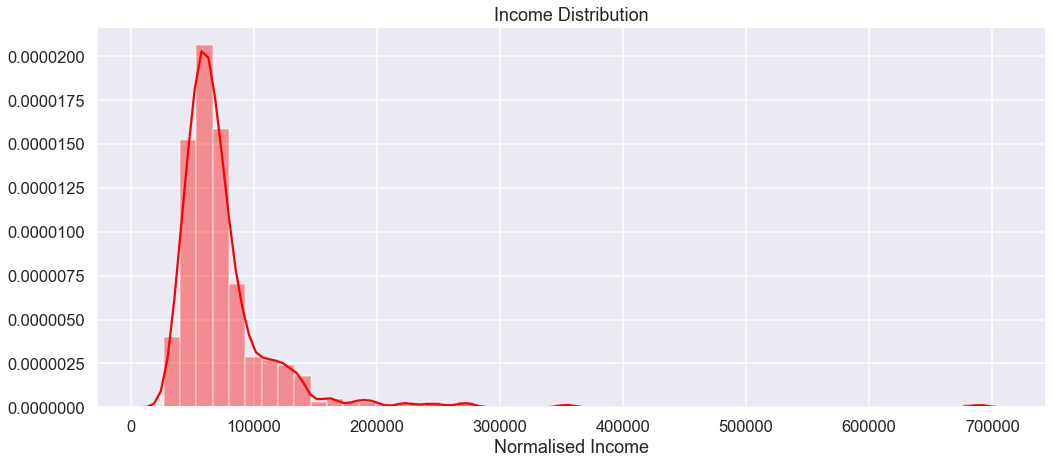

In [10]:
sns.distplot(a = income_obesity_df['Income'], bins=50, color="red")
plt.xlabel('Normalised Income')
plt.title('Income Distribution')

**Income Distribution** This distribution plots the relative densities of the average income of each city. Every city available in our dataset is used. On the x-axis, we have the normalised, average income of each city. We see that incomes range between 0 dollars - ~700,000 dollars with most values lying between 0 dollars and ~200,000 dollars. Additionally, the distribution is extremely right skewed. On the y-axis we have the density of the number of cities with a given income compared to the total number of cities in the dataset.

Since our data is heavily right skewed, in order to remove outliers from our dataset, we have elected to focus on the majority of cities in the dataset, those being the ones where income falls between 0 dollars and 200,000 dollars

In [11]:
income_obesity_df=income_obesity_df[income_obesity_df.Income <= 200000]
income_obesity_df

,State,City,Income,Population,Obesity,Diabetes,HighChol,Sleep,Stroke,Kidney
0,AK,Anchorage,80082.071574,291826,34.1,8.1,29.2,30.7,2.6,2.6
1,AL,Birmingham,76833.030036,212237,42.0,16.2,31.9,41.8,5.1,4.0
2,AL,Huntsville,69611.894834,180105,36.2,11.4,30.3,38.3,3.5,3.1
3,AL,Mobile,48140.928722,195111,38.2,13.5,31.5,39.7,4.2,3.5
4,AL,Montgomery,50277.532893,205764,39.0,14.3,32.2,38.1,4.2,3.6
...,...,...,...,...,...,...,...,...,...,...
466,WI,Milwaukee,55715.968969,594833,36.2,11.3,29.6,39.2,4.1,3.7
467,WI,Racine,54268.532091,78860,40.2,10.1,30.7,39.8,3.4,3.3
468,WI,Waukesha,73482.491157,70718,31.5,7.5,29.1,33.2,2.5,2.6
469,WV,Charleston,62930.969785,51400,38.8,12.9,33.0,40.3,3.3,3.1


We have removed 8 cities from our dataset that have incomes higher than 200,000 dollars

In [12]:
#Add labels to city income statistics
city_income_stats["State"]=income_obesity_df.State
city_income_stats["City"]=income_obesity_df.City
city_income_stats = city_income_stats[["State", "City", "count", "mean", "std", "min", "25%", "50%", "75%", "max"]]
city_income_stats.head()

,State,City,count,mean,std,min,25%,50%,75%,max
0,AK,Anchorage,10.0,80082.071574,27250.331571,56511.271298,60504.617100,77610.355423,84213.541563,149529.906542
1,AL,Birmingham,28.0,76833.030036,72273.073614,25578.796562,29968.863049,40310.828036,100322.605431,335398.913043
2,AL,Huntsville,10.0,69611.894834,31858.476347,26571.163366,41076.803264,75812.810234,91339.734075,122208.576998
3,AL,Mobile,16.0,48140.928722,20011.566339,22539.000000,30926.396986,44714.246872,63097.060664,86580.983182
4,AL,Montgomery,12.0,50277.532893,19466.386427,27329.139073,32866.644477,46270.325944,68899.262126,80899.237805


Text(0.5, 1.0, 'Income Distribution')

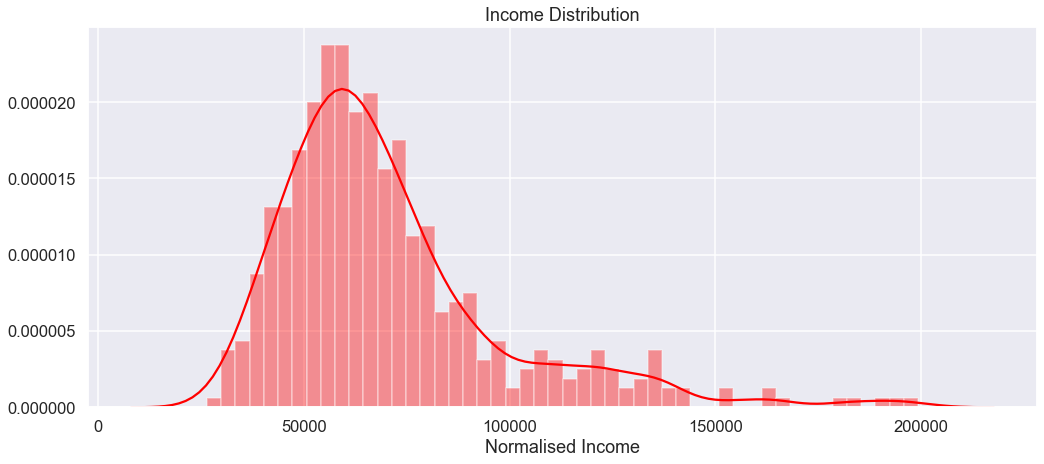

In [13]:
sns.distplot(a = income_obesity_df['Income'], bins=50, color="red")
plt.xlabel('Normalised Income')
plt.title('Income Distribution')

**Income Distribution** This distribution plots the relative densities of the average income of each city. Every city available in our revised dataset is used. On the x-axis, we have the normalised, average income of each city. We see that incomes range between 0 dollars - ~200,000 dollars. Additionally, the distribution is still right skewed, though significantly less than before. On the y-axis we have the density of the number of cities with a given income compared to the total number of cities in the dataset.

The following plot is presents the distribution of the percentage of obese individuals in each city:

Text(0.5, 1.0, 'Obesity Distribution')

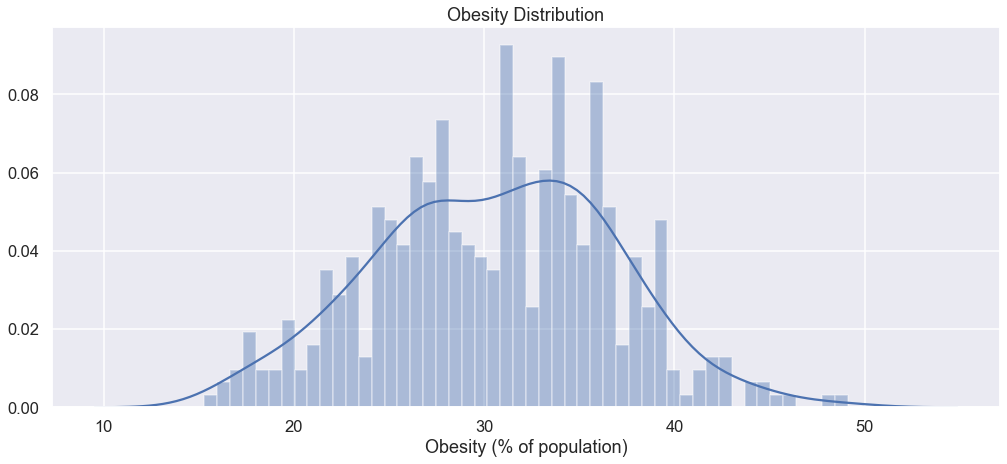

In [14]:
sns.distplot(a=income_obesity_df['Obesity'], bins=50)
plt.xlabel('Obesity (% of population)')
plt.title('Obesity Distribution')

**Obesity Distribution** This distribution plots the relative densities of the percentage of obesity within each city. Every city available in our revised dataset is used. On the x-axis, we have obesity as a percentage of the city's population. We see that obesity rates range between ~10% to ~55% with most values lying between 20 and 40%. Additionally, the data is somewhat normally distributed. On the y-axis we have the density of the number of cities with a given obesity percentage compared to the total number of cities in the dataset.

The following plot is presents the distribution of the percentage of individuals with a sleep deficiency in each city:

Text(0.5, 1.0, 'Sleep Distribution')

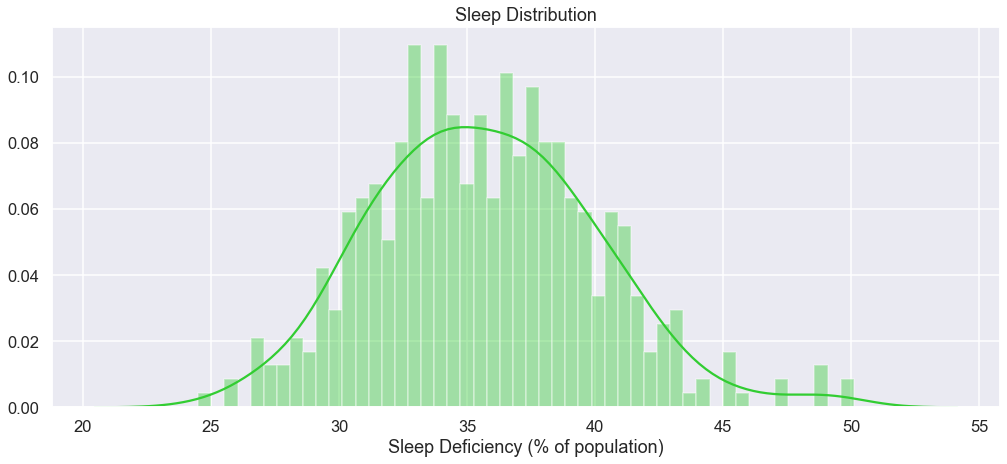

In [15]:
sns.distplot(a=income_obesity_df['Sleep'], bins=50, color="limegreen")
plt.xlabel('Sleep Deficiency (% of population)')
plt.title("Sleep Distribution")

**Sleep Distribution** This distribution plots the relative densities of the percentage of individuals with sleep deficiency within each city. Sleep deficiency is defined as getting less than 7 hours of sleep daily on average. Every city available in our revised dataset is used. On the x-axis, we have sleep deficiency as a percentage of the city's population. We see that sleep deficiency rates range between ~20% to ~55% with most values lying between 30 and 40%. Additionally, the data is mostly normally distributed. On the y-axis we have the density of the number of cities with a given sleep deficiency percentage compared to the total number of cities in the dataset.

The following plot is presents the distribution of the percentage of individuals with kidney disease in each city:

Text(0.5, 1.0, 'Kidney Disease Distribution')

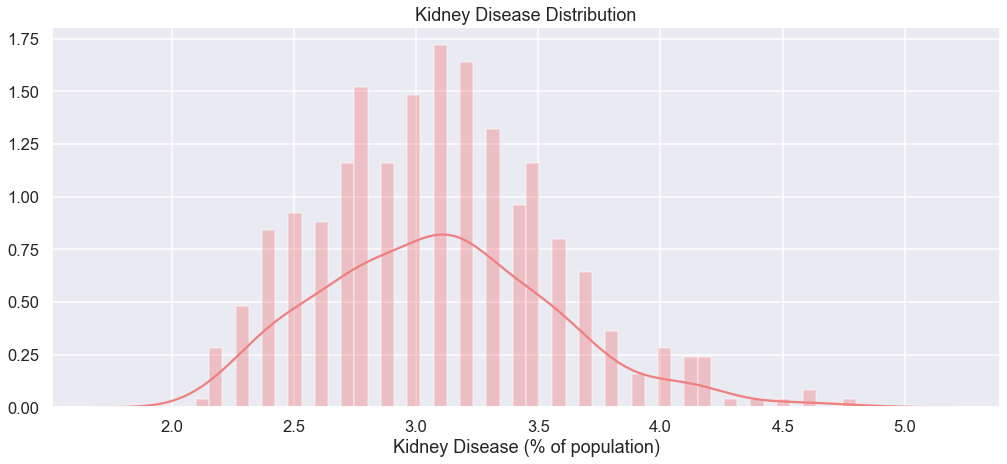

In [16]:
sns.distplot(a=income_obesity_df['Kidney'], bins=50, color="lightcoral")
plt.xlabel('Kidney Disease (% of population)')
plt.title('Kidney Disease Distribution')

**Kidney Disease Distribution** This distribution plots the relative densities of the percentage of individuals with kidney disease within each city. Every city available in our revised dataset is used. On the x-axis, we have kidney disease as a percentage of the city's population with kidney disease. We see that kidney disease rates range between ~2% to ~5% of the population with most values lying between 2.5 and 3.5%. Additionally, the data is slightly right skewed. On the y-axis we have the density of the number of cities with a given kidney disease percentage compared to the total number of cities in the dataset.

The following plot is presents the distribution of the percentage of individuals with high cholestorol in each city:

Text(0.5, 1.0, 'High Cholesterol Distribution')

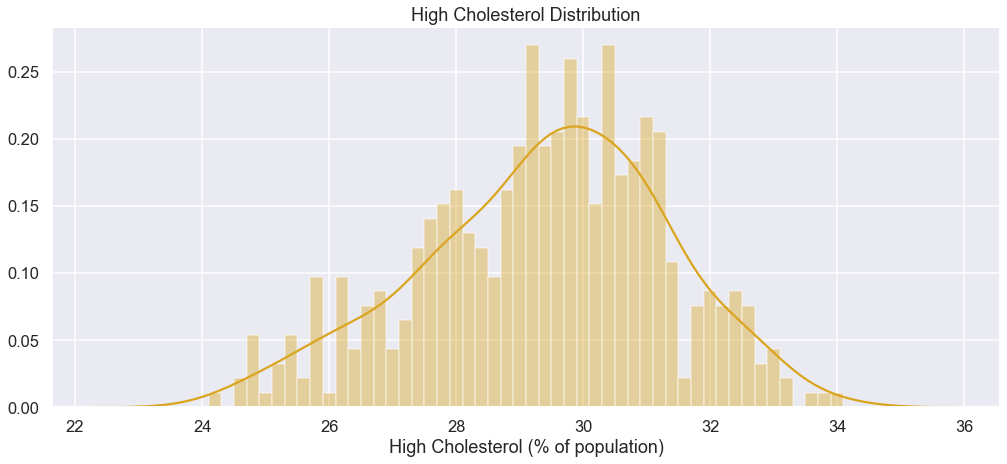

In [17]:
sns.distplot(a=income_obesity_df['HighChol'], bins=50, color="goldenrod")
plt.xlabel('High Cholesterol (% of population)')
plt.title('High Cholesterol Distribution')

**High Cholesterol Distribution** This distribution plots the relative densities of the percentage of individuals with high cholestorol within each city. Every city available in our revised dataset is used. On the x-axis, we have high cholestorol as a percentage of the city's population with high cholestorol. We see that high cholesterol rates range between ~23% to ~35% with most values lying between 28 and 32%. Additionally, the data is somewhat left skewed. On the y-axis we have the density of the number of cities with a given high cholestorol percentage compared to the total number of cities in the dataset.

The following plot is presents the distribution of the percentage of individuals that have experienced a stroke in each city:

Text(0.5, 1.0, 'Stroke Distribution')

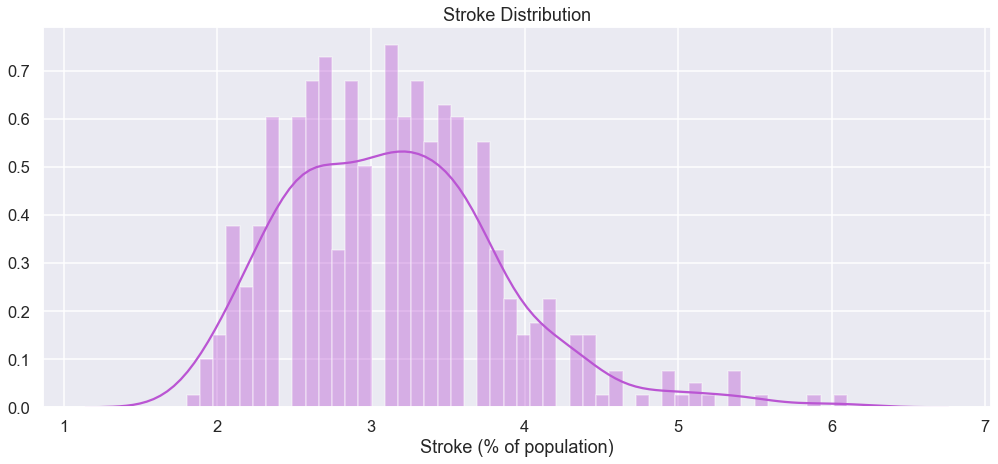

In [18]:
sns.distplot(a=income_obesity_df['Stroke'], bins=50, color="mediumorchid")
plt.xlabel('Stroke (% of population)')
plt.title('Stroke Distribution')

**Stroke Distribution** This distribution plots the relative densities of the percentage of individuals that have experienced a stroke within each city. Every city available in our revised dataset is used. On the x-axis, we have stroke as a percentage of the city's population that have experienced a stroke. We see that stroke rates range between ~1% to ~7% with most values lying between 2 and 4%. Additionally, the data is right skewed. On the y-axis we have the density of the number of cities with a given high cholestorol percentage compared to the total number of cities in the dataset.

The following plot is presents the distribution of the percentage of individuals with diabetes in each city:

Text(0.5, 1.0, 'Diabetes Distribution')

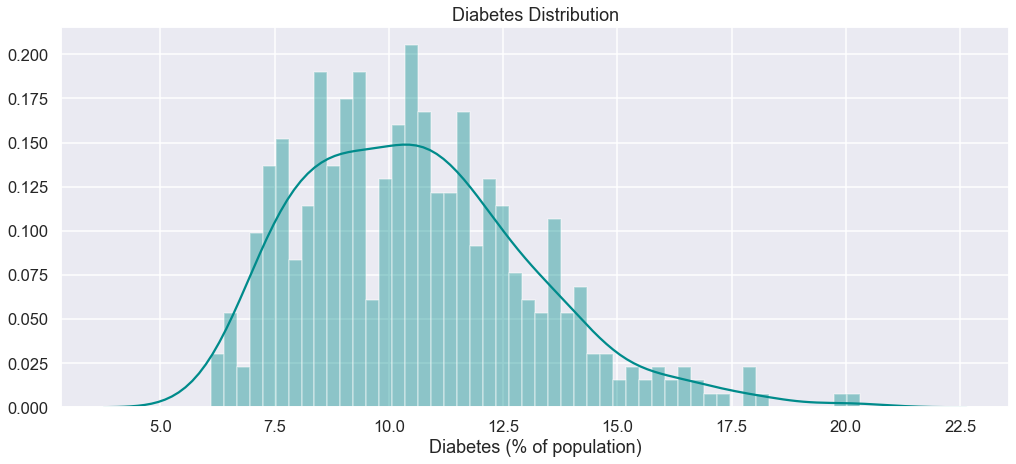

In [19]:
sns.distplot(a=income_obesity_df['Diabetes'], bins=50, color="darkcyan")
plt.xlabel('Diabetes (% of population)')
plt.title('Diabetes Distribution')

**Diabetes Distribution** This distribution plots the relative densities of the percentage of individuals with diabetes within each city. Every city available in our revised dataset is used. On the x-axis, we have diabetes as a percentage of the city's population with diabetes. We see that diabetes rates range between ~5% to ~22.5% with most values lying between 7.5 and 12.5%. Additionally, the data is somewhat right skewed. On the y-axis we have the density of the number of cities with a given diabetes percentage compared to the total number of cities in the dataset.

The following plot is presents the relationship matrix between each of our variables

Text(0.5, 0.98, 'Relationship Matrix')

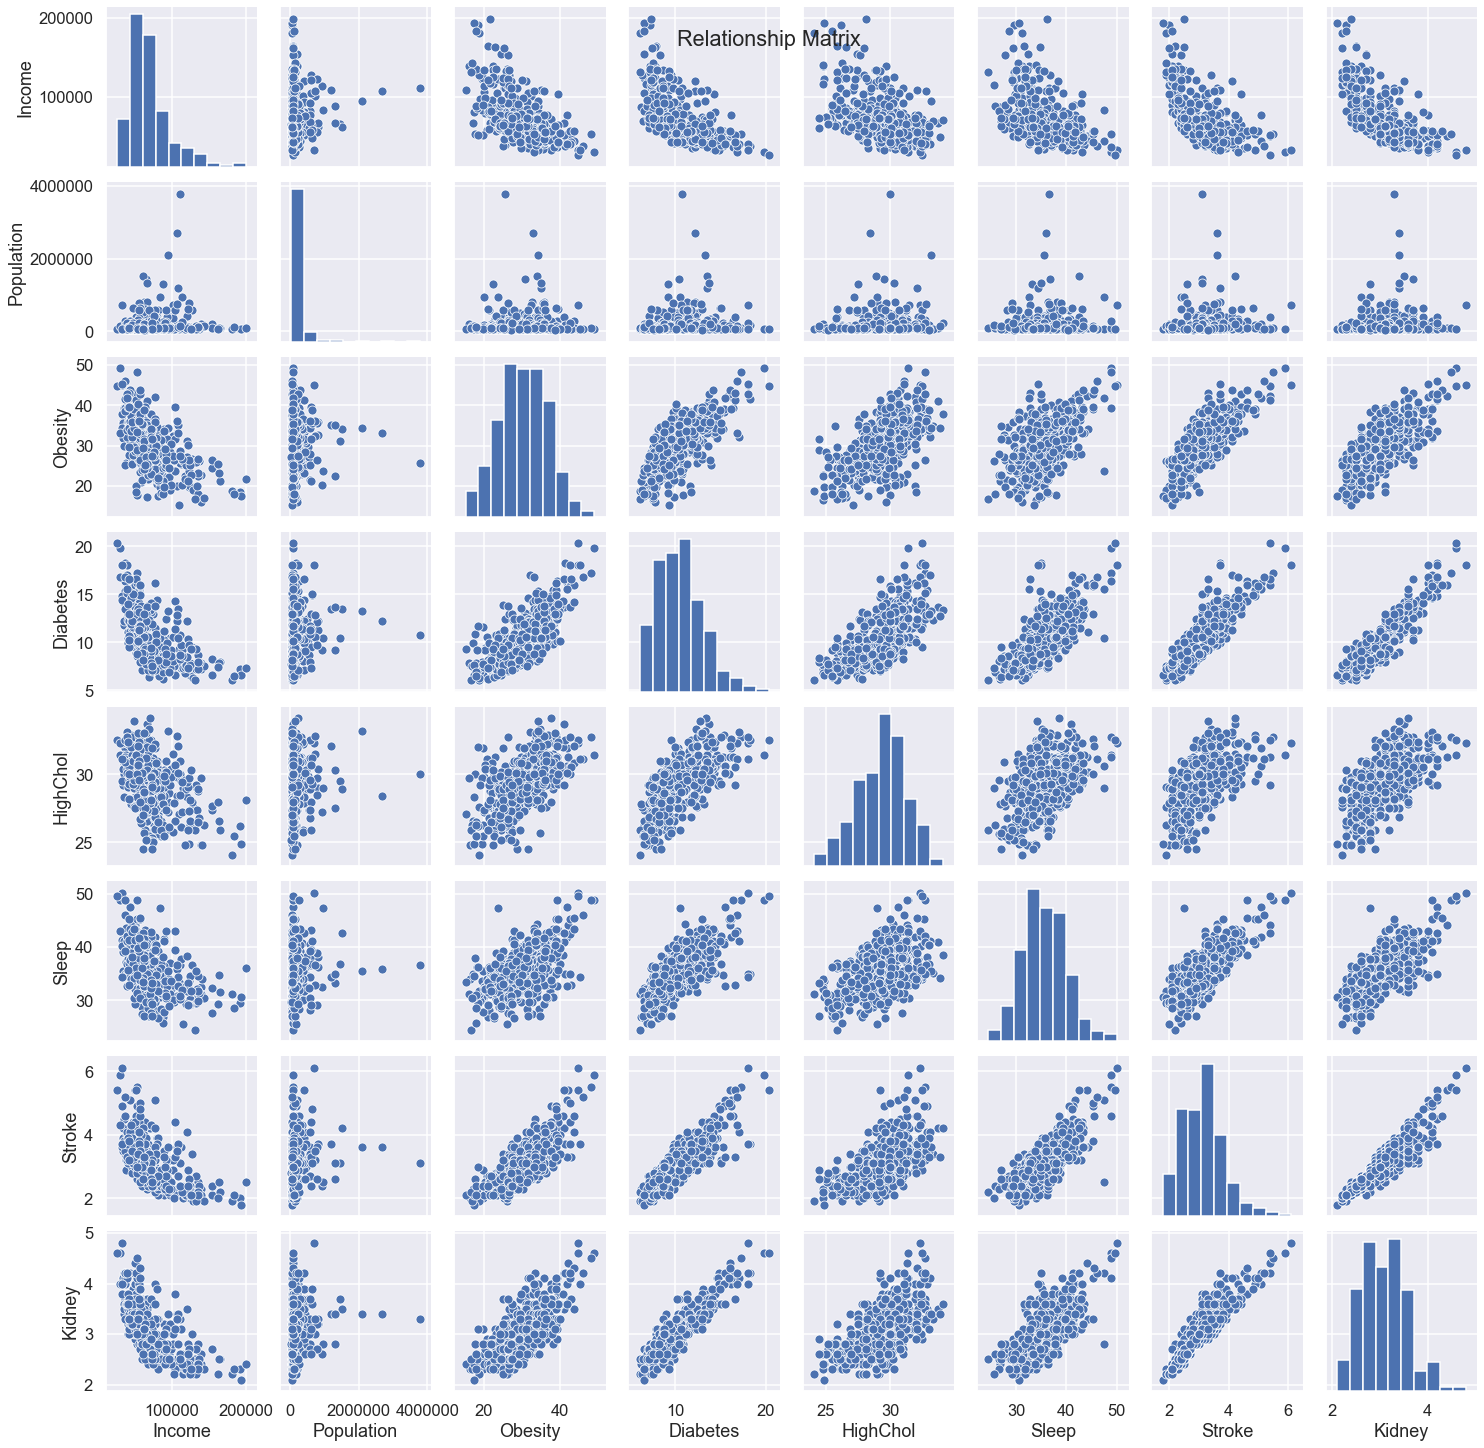

In [20]:
sns.pairplot(income_obesity_df)
plt.suptitle('Relationship Matrix')

**Relationship Matrix** This plot illustrates the relationships between each variable with one another. We see that income and population are highly left shifted and diabetes, stroke, and kidney metrics are slightly left shifted. Obesity, diabetes, high cholestorol, sleep deficiency, stroke, and kidney disease all appear to be somewhat positively correlated with each other. Income appears to have a negative exponential relationship with obesity, diabetes, high cholesterol, sleep, stroke, and kidney disease. 

The following plot is presents the correlation matrix between each of our variables

Text(0.5, 1, 'Correlation Matrix')

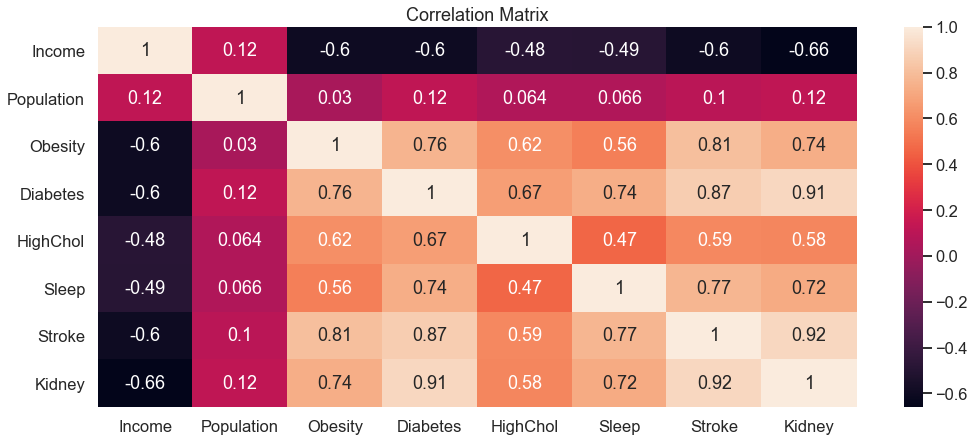

In [21]:
sns.heatmap(income_obesity_df.corr(), annot=True)
plt.title('Correlation Matrix')

**Correlation Matrix** This plot illustrates the correlations between each variable with one another. We see that income appears to have a negative correlation with the health variables. Obesity, diabetes, high cholestorol, sleep deficiency, stroke, and kidney disease all appear to be somewhat positively correlated with each other.

Because of this intercorrelatedness of the variables, it is important to account for each of the health variables in our predictive model.